# Run a SU2 Simulation on a Specific Airfoil
In this tutorial we walk through running and analyzing data from a SU2 simulation for an airfoil.

**_Note:_** The simulations assume/create the following conditions:
1. The airfoil is of length 1. The Reynolds number is sized according to a reference length of 1.  
   And it is not dependent on the actual length of the airfoil.
1. The code places the centroid of the airfoil at the origin.
1. The code rotates the airfoil clockwise by specified angle of attack about the origin.

First some basic imports. The main function to import is `su2_simulation_func` that runs our SU2
simulation.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from cfd_utils.su2_simulation_func import su2_simulation_func

## Define Simulation Configurations
We need to define some necessary simulation properties.

Note that the mesh fineness can be changed by tuning the `mesh_size_at_airfoil` parameter.

The type of simulation can be chosen to be `EULER` or `RANS`.

Note that the Reynolds number indirectly depends on the Mach number (`Mach_num`).

The simulation can be run at a different angle of attack by specifying `angle_of_attack` (in
degrees) which creates a new mesh for the rotated airfoil (instead of rotating the mesh for the
original airfoil).

The simulation convergence conditions can be set using `max_iterations` and `conv_residual`.

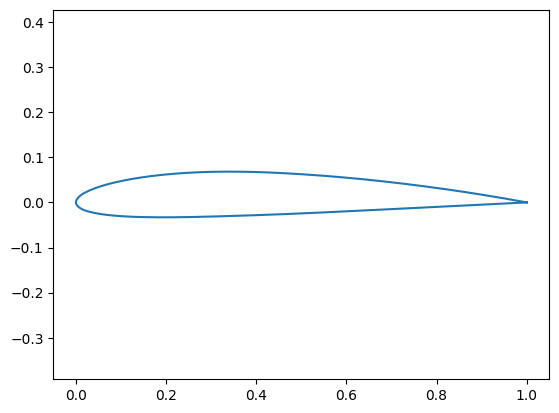

In [2]:
# Get the geometry
airfoil_name = 'naca2410'
airfoil_coordinate_file_dir = Path('./airfoil_utils/airfoils')
airfoil_filename = airfoil_name + '.dat'
airfoil_coordinate_file_path = airfoil_coordinate_file_dir / airfoil_filename
X = np.loadtxt(airfoil_coordinate_file_path)

# Visualize the geometry
plt.plot(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

In [3]:
# Define simulation properties
Mach_num = 0.25
mesh_factor_at_airfoil = 5.0
mesh_size_at_farfield = 5.0
farfield_factor = 100
fan_count = 20
type_of_simulation = 'EULER'
simulation_data_save_dir = Path(f'./dataset/{type_of_simulation}')
max_iterations = 4000
conv_residual = 1e-7
angle_of_attack = 0

## Run Simulation
We can now run our simulation using the `su2_simulation_func` function. This saves our data in the
SU2 file formats and also in `.npy` files for easy and fast reading using numpy.

The function returns simulation details which can be investigated to check that the simulation
parameters made sense and whether the simulation converged or not amongst other useful information.

In [4]:
# Run the simulation and save the data
simulation_info = su2_simulation_func(
    airfoil_name = airfoil_name,
    X = X,
    Mach_num = Mach_num,
    mesh_factor_at_airfoil = mesh_factor_at_airfoil,
    mesh_size_at_farfield = mesh_size_at_farfield,
    farfield_factor = farfield_factor,
    fan_count = fan_count,
    type_of_simulation = type_of_simulation,
    simulation_data_save_dir = simulation_data_save_dir,
    max_iterations = max_iterations,
    conv_residual = conv_residual,
    angle_of_attack_deg = angle_of_attack
)

if not simulation_info['converged']:
    print(f'DID NOT CONVERGE. Airfoil: {airfoil_name:{15}} AoA: {angle_of_attack:2d}')

# Print simulation info
import json
print(json.dumps(simulation_info, indent = 4))

{
    "airfoil_name": "naca2410",
    "AoA": 0,
    "mesh_info": {
        "consecutive_point_min_dist": 0.0002470423471037093,
        "consecutive_point_max_dist": 0.015739441822610056,
        "Re": 5823484.750152016,
        "y_H": 9.17866418639192e-06,
        "delta_99": 0.016855708347353334,
        "G": 1.2,
        "N": 34,
        "BL_thickness": 0.022543878849807967,
        "mesh_generation_time": 0.6396663188934326,
        "mesh_details": {
            "num_nodes": 35301,
            "num_elements": 45599,
            "physical_groups": {
                "airfoil_curves": [
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
                    8,
                    9,
                    10,
                    11,
                    12,
                    13,
                    14,
                    15,
                    16,
                    17,
      

## Analyzing the Simulation Results
We can read the following simulation data files that SU2 produces:
1. `history.csv`
1. `surface_flow.csv`
1. `flow.vtu`

The simulation function `su2_simulation_func` automatically reads data from these files and saves
the information in `.npy` format to allow easy and fast reading for downstream tasks.

Inner_Iter
Time(sec)
rms[Rho]
rms[RhoU]
rms[RhoV]
rms[RhoE]
CD
CL


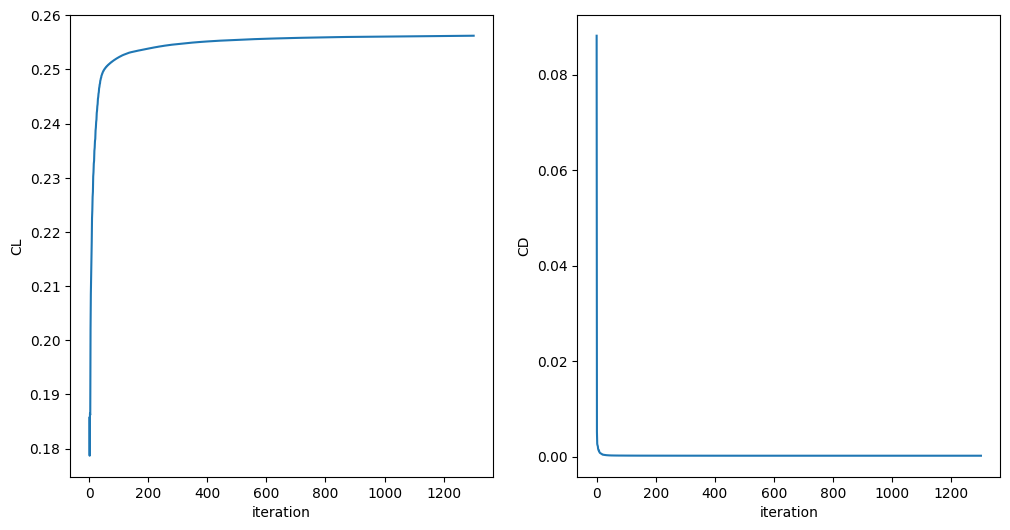

In [5]:
# Read history data
history_data = np.load(simulation_data_save_dir / airfoil_name / f'AoA_{str(angle_of_attack)}'
                       / 'history.npy', mmap_mode = 'r')

for header in history_data.dtype.names:
    print(header)

# Access data column-wise taking advantage of lazy loading
iteration = history_data['Inner_Iter']
CL = history_data['CL']
CD = history_data['CD']

# Example - plot the variation of CL and CD with iteration count
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(iteration, CL)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('CL')
ax[1].plot(iteration, CD)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('CD')

plt.show()

PointID
x
y
Density
Momentum_x
Momentum_y
Energy


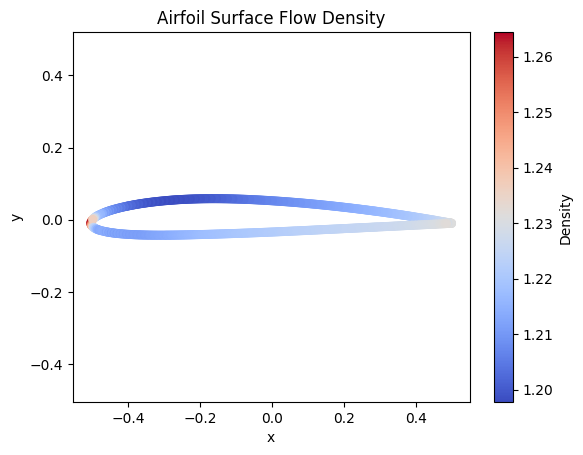

In [6]:
# Read surface flow data
surface_data = np.load(simulation_data_save_dir / airfoil_name / f'AoA_{str(angle_of_attack)}'
                       / 'surface_flow.npy', mmap_mode = 'r')

for header in surface_data.dtype.names:
    print(header)

# Access data column-wise taking advantage of lazy loading
x = surface_data['x']
y = surface_data['y']
density = surface_data['Density']

# Example - plot the variation of density on the surface
sc = plt.scatter(x, y, c = density, cmap = 'coolwarm', s = 30)
plt.colorbar(sc, label = 'Density')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Airfoil Surface Flow Density')
plt.show()

x
y
Density
Momentum_x
Momentum_y
Energy
Pressure
Temperature
Mach
Pressure_Coefficient
Velocity_x
Velocity_y


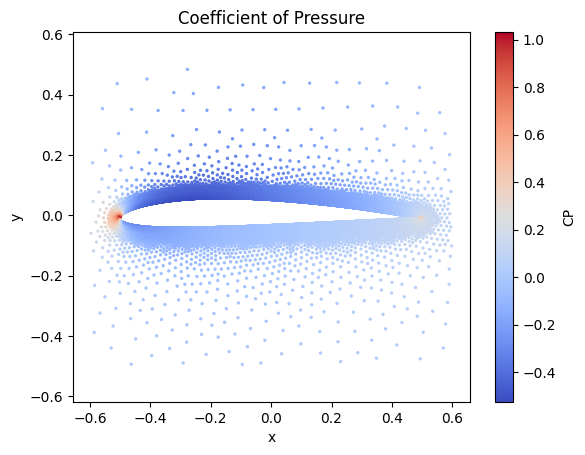

In [7]:
# Read volume flow data
flow_data = np.load(simulation_data_save_dir / airfoil_name / f'AoA_{str(angle_of_attack)}'
                    / 'flow.npy', mmap_mode = 'r')

for header in flow_data.dtype.names:
    print(header)

# Access data column-wise taking advantage of lazy loading
x = flow_data['x']
y = flow_data['y']
CP = flow_data['Pressure_Coefficient']

# Visualize only data points close to the airfoil
idx = (x >= -0.6) & (x <= 0.6) & (y >= -0.5) & (y <= 0.5)
x = x[idx]
y = y[idx]
CP = CP[idx]

# Example - plot the variation of density on the surface
sc = plt.scatter(x, y, c = CP, cmap = 'coolwarm', s = 2)
plt.colorbar(sc, label = 'CP')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Coefficient of Pressure')
plt.show()